In [10]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

from pyvis.network import Network
from cdlib import algorithms


In [11]:
# adjust the filename if yours is different
edges = pd.read_csv("country_relationships_edges.csv")

# ensure canonical column names
edges = edges.rename(columns=str.lower)   # in case cols are "Source","Target","Weight"
edges = edges[["source","target","weight"]]
edges["weight"] = edges["weight"].astype(float)
edges.head()


,source,target,weight
0,germany,united kingdom,4.0
1,iran,united states,3.0
2,france,united kingdom,3.0
3,china,japan,2.0
4,austria,sweden,2.0


### Build a NetworkX graph (and guarantee weights exist)

In [5]:
net = Network(height="750px", width="100%", bgcolor="#ffffff", font_color="#222")
net.barnes_hut(gravity=-20000, spring_length=140, spring_strength=0.02)
net.from_nx(G)

for n in net.nodes:
    s = strength.get(n["id"], 1.0)
    n["size"]  = max(10, s*1.2)
    n["title"] = f"{n['id']}<br>strength={s:.1f}"

for e in net.edges:
    e["width"] = max(1, np.sqrt(e.get("value", 1)))
    e["title"] = f"weight={e.get('value', 1)}"

html_static = "network_static.html"
net.show(html_static)
print("Saved:", html_static)


Saved: network_static.html


### Leiden communities (via cdlib)

In [12]:
G = nx.Graph()

# combine duplicate pairs and add weight
for (u, v), g in edges.groupby(["source","target"], as_index=False):
    w = float(g["weight"].sum())
    if G.has_edge(u, v):
        G[u][v]["weight"] += w
    else:
        G.add_edge(u, v, weight=w)

# make sure every edge has a weight (defensive)
for u, v, data in G.edges(data=True):
    data.setdefault("weight", 1.0)

print(f"Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")


Nodes: 33, Edges: 57


### Static NetworkX plo 

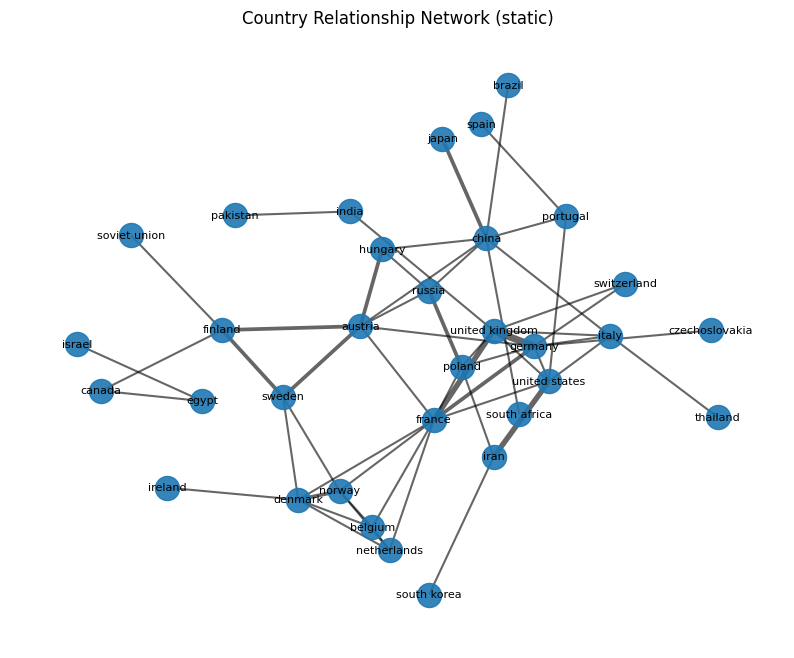

In [13]:
plt.figure(figsize=(10,8))
pos = nx.spring_layout(G, k=0.6, seed=42, weight="weight")
nx.draw_networkx_nodes(G, pos, node_size=300, alpha=0.9)
nx.draw_networkx_edges(G, pos, width=[0.3 + 1.2*data["weight"] for *_, data in G.edges(data=True)], alpha=0.6)
nx.draw_networkx_labels(G, pos, font_size=8)
plt.axis("off")
plt.title("Country Relationship Network (static)")
plt.show()


### Interactive PyVis graph (HTML)

In [14]:
net = Network(height="700px", width="100%", bgcolor="#ffffff", font_color="#222")
net.from_nx(G)  # imports nodes/edges and attributes
# map weights to thickness for visibility
for e in net.edges:
    w = e.get("weight", 1)
    e["value"] = float(w)
    e["width"] = 1 + 2*float(w)

net.show("20th_century_network.html")


### Leiden communities (fixing your error)

In [16]:
import igraph, leidenalg

print("igraph version:", igraph.__version__)
print("leidenalg available:", hasattr(leidenalg, "find_partition"))



igraph version: 0.11.9
leidenalg available: True


In [18]:
for u, v, data in G.edges(data=True):
    data.setdefault("weight", 1.0)


In [19]:
from cdlib import algorithms

# Run Leiden with weights
part = algorithms.leiden(G, weights="weight")

print(f"Leiden → {len(part.communities)} communities")


Leiden → 5 communities


In [20]:
# if the 'weight' attribute exists (we ensured it), pass weights="weight"
part = algorithms.leiden(G, weights="weight")

print(f"Leiden → {len(part.communities)} communities")

# attach community id to nodes
comm_map = {}
for cid, members in enumerate(part.communities):
    for node in members:
        comm_map[node] = cid

nx.set_node_attributes(G, comm_map, "community")


Leiden → 5 communities


### Visualize communities and save HTML

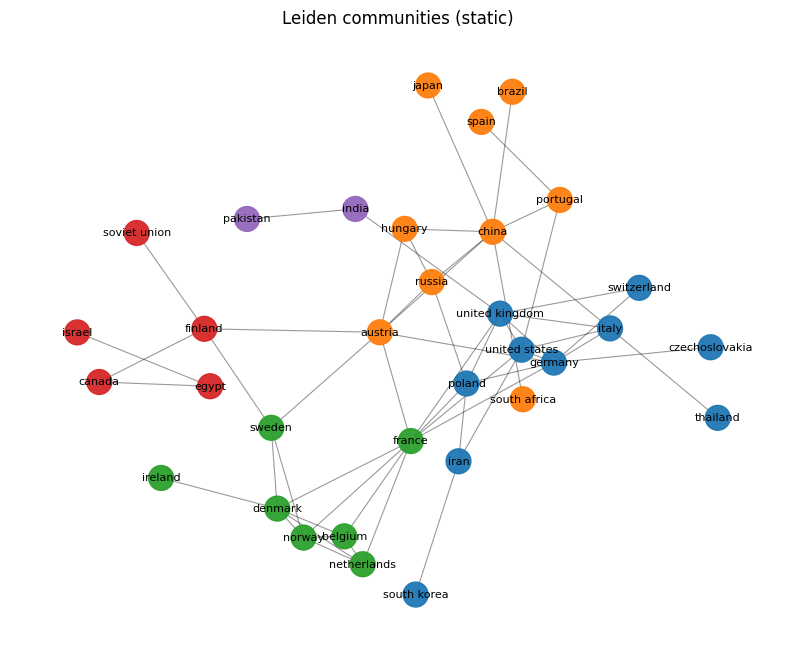

In [21]:
# palette for communities
import matplotlib.colors as mcolors
colors = list(mcolors.TABLEAU_COLORS.values())

plt.figure(figsize=(10,8))
pos = nx.spring_layout(G, k=0.6, seed=42, weight="weight")
node_colors = [colors[nx.get_node_attributes(G, "community").get(n, 0) % len(colors)] for n in G.nodes()]

nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=320, alpha=0.95)
nx.draw_networkx_edges(G, pos, width=0.8, alpha=0.4)
nx.draw_networkx_labels(G, pos, font_size=8)
plt.axis("off")
plt.title("Leiden communities (static)")
plt.show()


In [22]:
net_comm = Network(height="700px", width="100%", bgcolor="#ffffff", font_color="#222")
net_comm.from_nx(G)
for n in net_comm.nodes:
    cid = G.nodes[n["id"]].get("community", 0)
    n["group"] = int(cid)  # PyVis groups color automatically

net_comm.show("20th_century_communities.html")


- Countries cluster into X communities that broadly align with historical alliances/blocs (e.g., Allied vs Axis, NATO/Western vs Warsaw Pact, colonial relationships, etc.).
- Heavier edges indicate frequent co-mentions (shared wars, treaties, decolonization events).
- A few “bridge” nodes connect communities (interpret as diplomatic intermediaries or theaters involving multiple blocs).

### Centrality metrics (degree, closeness, betweenness)

In [23]:
deg = nx.degree_centrality(G)
clo = nx.closeness_centrality(G, distance=lambda u,v,d: 1/d.get("weight",1))
bet = nx.betweenness_centrality(G, weight="weight", normalized=True)

cent_df = (
    pd.DataFrame({
        "country": list(G.nodes()),
        "degree": [deg[n] for n in G.nodes()],
        "closeness": [clo[n] for n in G.nodes()],
        "betweenness": [bet[n] for n in G.nodes()],
        "community": [G.nodes[n].get("community", None) for n in G.nodes()],
    })
    .sort_values(["degree","betweenness"], ascending=False)
)

cent_df.head(15)


,country,degree,closeness,betweenness,community
3,france,0.28125,0.463768,0.249933,2
1,china,0.25000,0.415584,0.247782,1
4,germany,0.25000,0.457143,0.168705,0
0,austria,0.21875,0.463768,0.344344,1
24,united kingdom,0.21875,0.415584,0.150084,0
25,united states,0.18750,0.410256,0.126254,0
9,denmark,0.18750,0.363636,0.075224,2
15,italy,0.15625,0.395062,0.111811,0
23,poland,0.15625,0.395062,0.071360,0
11,norway,0.15625,0.359551,0.012724,2


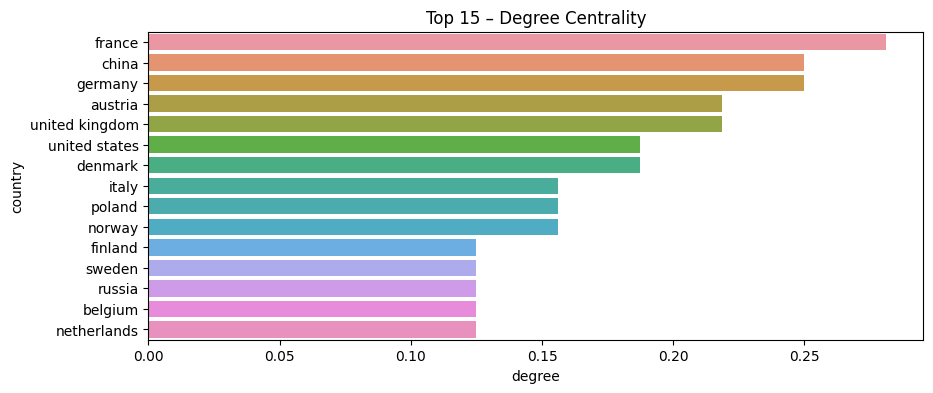

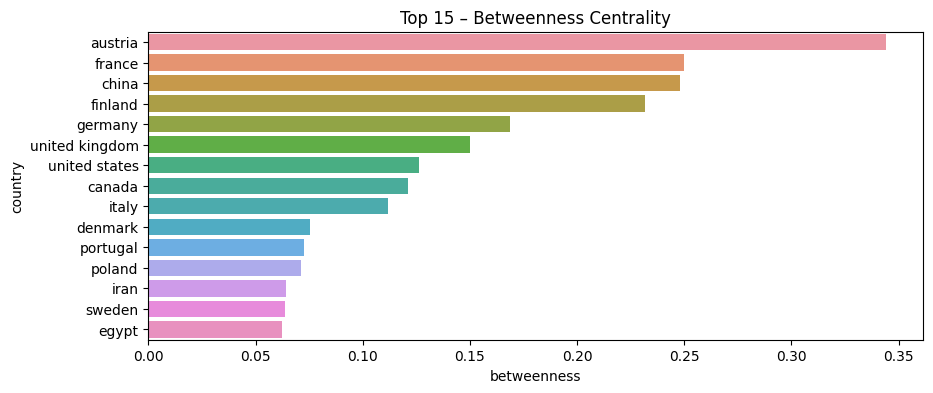

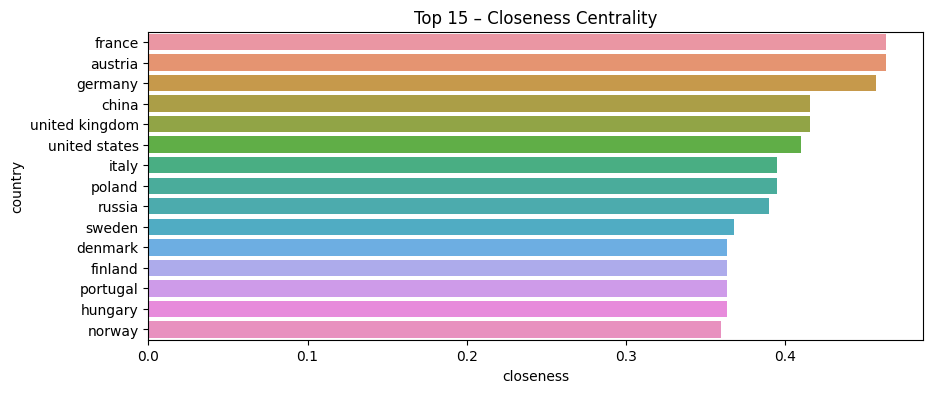

In [24]:
plt.figure(figsize=(10,4))
sns.barplot(data=cent_df.nlargest(15,"degree"), x="degree", y="country")
plt.title("Top 15 – Degree Centrality"); plt.show()

plt.figure(figsize=(10,4))
sns.barplot(data=cent_df.nlargest(15,"betweenness"), x="betweenness", y="country")
plt.title("Top 15 – Betweenness Centrality"); plt.show()

plt.figure(figsize=(10,4))
sns.barplot(data=cent_df.nlargest(15,"closeness"), x="closeness", y="country")
plt.title("Top 15 – Closeness Centrality"); plt.show()


- Degree → who’s connected to the most countries (broadly “busy” players).
- Betweenness → who acts as bridges across communities/conflicts (often pivotal in wars/alliances).
- Closeness → who can “reach” others quickly in the network (central theaters or diplomatic hubs).